# TOPIC MODELING USING WIKIPEDIA ARTICLES

The goal of this notebook is to classify text using wikipedia articles as a source of training data.

Some pieces of code and ideas were taken from https://github.com/abhijeet3922/Topic-Modelling-on-Wiki-corpus

## 1) Import libraries

In [1]:
import xml.etree.ElementTree as ET
import codecs
import re
import os
import random
import pickle
from gensim.models.ldamodel import LdaModel as Lda
from gensim import corpora
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from wordcloud import WordCloud
import string
from bs4 import BeautifulSoup
from operator import itemgetter
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# nltk.download()



## 2) Prepare the wikipedia training dataset

Our text classifier would classify our text using wikipedia articles. For that, it is necessary to have the latest wikipedia pages in form of .xml file, retrieved from https://dumps.wikimedia.org/enwiki/latest/
Also other wikipedia dumps can be used for this purpose.

In [2]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

def prepare_training(dir_path):
    tree = ET.parse('simplewiki-latest-pages-articles-multistream.xml')
    root = tree.getroot()
    try:
        os.mkdir(dir_path)
    except:
        pass
    
    for i,page in enumerate(root.findall('{http://www.mediawiki.org/xml/export-0.10/}page')):
        for p in page:    
            if p.tag == "{http://www.mediawiki.org/xml/export-0.10/}revision":
                for x in p:
                    if x.tag == "{http://www.mediawiki.org/xml/export-0.10/}text":                    
                        article_txt = x.text
                        if not article_txt == None:                                                
                            article_txt = article_txt[ : article_txt.find("==")]
                            article_txt = re.sub(r"{{.*}}","",article_txt)
                            article_txt = re.sub(r"\[\[File:.*\]\]","",article_txt)
                            article_txt = re.sub(r"\[\[Image:.*\]\]","",article_txt)
                            article_txt = re.sub(r"\n: \'\'.*","",article_txt)
                            article_txt = re.sub(r"\n!.*","",article_txt)
                            article_txt = re.sub(r"^:\'\'.*","",article_txt)
                            article_txt = re.sub(r"&nbsp","",article_txt)
                            article_txt = re.sub(r"http\S+","",article_txt)
                            article_txt = re.sub(r"\d+","",article_txt)   
                            article_txt = re.sub(r"\(.*\)","",article_txt)
                            article_txt = re.sub(r"Category:.*","",article_txt)
                            article_txt = re.sub(r"\| .*","",article_txt)
                            article_txt = re.sub(r"\n\|.*","",article_txt)
                            article_txt = re.sub(r"\n \|.*","",article_txt)
                            article_txt = re.sub(r".* \|\n","",article_txt)
                            article_txt = re.sub(r".*\|\n","",article_txt)
                            article_txt = re.sub(r"{{Infobox.*","",article_txt)
                            article_txt = re.sub(r"{{infobox.*","",article_txt)
                            article_txt = re.sub(r"{{taxobox.*","",article_txt)
                            article_txt = re.sub(r"{{Taxobox.*","",article_txt)
                            article_txt = re.sub(r"{{ Infobox.*","",article_txt)
                            article_txt = re.sub(r"{{ infobox.*","",article_txt)
                            article_txt = re.sub(r"{{ taxobox.*","",article_txt)
                            article_txt = re.sub(r"{{ Taxobox.*","",article_txt)
                            article_txt = re.sub(r"\* .*","",article_txt)
                            article_txt = re.sub(r"<.*>","",article_txt)
                            article_txt = re.sub(r"\n","",article_txt)  
                            article_txt = re.sub(r"\!|\"|\#|\$|\%|\&|\'|\(|\)|\*|\+|\,|\-|\.|\/|\:|\;|\<|\=|\>|\?|\@|\[|\\|\]|\^|\_|\`|\{|\||\}|\~"," ",article_txt)
                            article_txt = re.sub(r" +"," ",article_txt)
                            article_txt = article_txt.replace('\xa0', ' ')
                           
                            if not article_txt == None and not article_txt == "" and len(article_txt) > 150 and is_ascii(article_txt):
                                outfile = dir_path + str(i+1) +"_article.txt"
                                f = codecs.open(outfile, "w", "utf-8")
                                f.write(article_txt)
                                f.close()


## 3) Running the models


In [3]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    normalized = " ".join(lemma.lemmatize(word,'v') for word in stop_free.split())
    x = normalized.split()
    y = [s for s in x if len(s) > 2]
    return y

def clean_BOW(original):
# This function cleans a wikipedia page, ending up in a bag of words (BOW)
    article_txt = BeautifulSoup(original, "lxml").text
    article_txt = re.sub(r"{{.*}}","",article_txt)
    article_txt = re.sub(r'[^\x00-\x7F]',' ', article_txt)
    article_txt = re.sub(r"\[\[File:.*\]\]","",article_txt)
    article_txt = re.sub(r"\[\[Image:.*\]\]","",article_txt)
    article_txt = " ".join([i for i in article_txt.lower().split()])
    nouns = [word for word,pos in nltk.pos_tag(nltk.word_tokenize(' '.join([i for i in article_txt.split()]))) if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    lemmat = " ".join(lemma.lemmatize(lemma.lemmatize(word),'v').translate({ord(ch): None for ch in '0123456789'}) for word in nouns  if ("@" not in word and '.com' not in word and 'www' not in word and 'http' not in word and '/' not in word  and '\\' not in word and ':' not in word))
    normalized = re.sub('[%s]' % re.escape(string.punctuation), ' ', lemmat).split()
    x= [s for s in normalized if s not in stop]
    y = [s for s in x if (len(s) > 2 and len(s) < 15) ]
    return y


def run_model(corpus_path):
    article_paths = [os.path.join(corpus_path,p) for p in os.listdir(corpus_path)]
    
    # Read contents of all the articles in a list "doc_complete"
    doc_complete = []
    for path in article_paths:
        fp = codecs.open(path,'r','utf-8')
        doc_content = fp.read()
        doc_complete.append(doc_content)  
    
    # Save the articles from the corpus in pickle format    
    docs_train = doc_complete
    docs = open("docs_wiki.pkl",'wb')
    pickle.dump(docs_train,docs)
    
    
    # Cleaning all the simplewiki articles
    stop = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
    doc_clean = [clean(doc) for doc in docs_train]
    
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. 
    dictionary = corpora.Dictionary(doc_clean)
    
    # Filter the terms which have occured in less than 3 articles and more than 40% of the articles 
    dictionary.filter_extremes(no_below=4, no_above=0.4)
    
    # List of some words which has to be removed from dictionary as they are content neutral words
    stoplist = set('also use make people know many call include part find become like mean often different \
                    usually take wikt come give well get since type list say change see refer actually iii \
                    aisne kinds pas ask would way something need things want every str'.split())
    stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
    dictionary.filter_tokens(stop_ids)
    
    
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    
    
    #Creating the object for LDA model using gensim library & Training LDA model on the document term matrix.
    ldamodel = Lda(doc_term_matrix, num_topics=50, id2word = dictionary, passes=50, iterations=500)
    ldafile = open('lda_model.pkl','wb')
    pickle.dump(ldamodel,ldafile)
    ldafile.close()
    num_groups=50
    
    #We plot the results
    try:
        os.mkdir('./figures')
    except:
        pass
    data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
    pyLDAvis.save_html(data,'./figures/lda_%sgroups.html'%num_groups)
    
    
    #Print all the 50 topics
    for topic in ldamodel.print_topics(num_topics=50, num_words=10):
        print(topic[0]+1, " ", topic[1],"\n")
    
    #Save all those topics in csv files
    try:
        os.mkdir('./groups')
    except:
        pass   
    with open('./groups/all_groups.csv', 'w', newline='') as g:
            for i,topic in enumerate(ldamodel.print_topics(num_topics=num_groups, num_words=100)):
                with open('./groups/group_%s_with_freqs.csv'%i, 'w', newline='') as f:
                    words = topic[1].split("+")
                    f.write(",".join(words))
                    words_nofreqs = [word.split("*")[1].replace(' ','').replace('"','') for word in topic[1].split("+")]
                    g.write(" ".join(words_nofreqs)+'\n')
    
    height=1+3*math.ceil(num_groups/3)
    fig = plt.figure(figsize=(18.,height))
    nh, nv = 3,math.ceil(num_groups/3)
    gs = gridspec.GridSpec(nv, nh)  
    i_plot=0
    for t in range(num_groups):
        ax = fig.add_subplot(gs[int(i_plot / nh), i_plot % nh])
        ax.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(t, 100))))
        ax.axis("off")
        ax.set_title("Topic %s"%t)
        i_plot += 1
    
    plt.savefig('./figures/wordclouds_%sgroups.pdf'%num_groups, bbox_inches='tight',dpi=72)



## 4) Validate with some wikipedia articles

In [4]:
def get_theme(ldamodel,doc):
    # This function prints the most probable groups in which the doc is classified, with probabilities
    # We load the LDA model
    # This is the list of labels for the 50 topics of the model. Change with your own classification
    topics = "Education Society France US Society Literature International Chemistry US Sports_and_gaming\
    numbers_and_dates Engineering Politics_and_Government International Was_and_military biology_and_medicine medicine languages Sports America_and_months\
    Canada__and_biology Weather Nature Energy Music IT political_geography UK_and_Ireland Canada_and_UK_Empire Geography\
    Calendar History History_and_literature Music Wikipedia_and_IT Animals Music_and_technology Economy Movies California_and_movies\
    Politics Politics Russia_and_US_affairs EU_and_US_affairs Entertainment Australia Sports Movies_and_TV Australia Geography".split()
       
    theme = ""
    cleandoc = clean_BOW(doc)
    doc_bow = ldamodel.id2word.doc2bow(cleandoc)
    doc_topics = ldamodel.get_document_topics(doc_bow, minimum_probability=0.05)
    if len(doc_topics) > 2:
        doc_topics.sort(key = itemgetter(1), reverse=True)
        theme = topics[doc_topics[0][0]]
        theme2 = topics[doc_topics[1][0]]
        theme3 = topics[doc_topics[2][0]]
        complete = 'Theme %s %.2f%% Theme %s %.2f%% Theme %s %.2f%%'%(theme,doc_topics[0][1],theme2,doc_topics[1][1],theme3,doc_topics[2][1])
    else:
        theme = topics[doc_topics[0][0]]
        complete = 'Theme %s %.2f%%'%(theme,doc_topics[0][1])
    return complete

def run_examples(model_path):
        ldamodel = pickle.load(open(model_path, 'rb'))
        article = " Britney Jean Spears (born December 2, 1981) is an American singer, dancer, and actress. Born in McComb, Mississippi, and raised in Kentwood, Louisiana, she appeared in stage productions and television series, before signing with Jive Records in 1997. Spears's first two studio albums, ...Baby One More Time (1999) and Oops!... I Did It Again (2000), were global successes and made her the best-selling teenage artist of all-time. Referred to as the Princess of Pop, Spears was credited with influencing the revival of teen pop during the late 1990s and early 2000s. Spears adopted more mature and provocative themes for her next two studio albums, Britney (2001) and In the Zone (2003), and made her feature film debut in a starring role in Crossroads (2002). Following a series of heavily publicized personal struggles and erratic public behavior, Spears' career underwent a brief hiatus before the release of her fifth studio album Blackout (2007), which is often critically referred to as her best work. Her erratic behavior and hospitalizations led Spears to be placed on a still ongoing conservatorship. She returned to the top of record charts with her sixth and seventh studio albums, Circus (2008) and Femme Fatale (2011). In 2012, Forbes reported that Spears was the highest paid female musician of the year, with earnings of $58 million, having last topped the list in 2002.[1] During the promotion of her eighth and ninth studio albums, Britney Jean (2013) and Glory (2016), Spears embarked on a four-year concert residency, Britney: Piece of Me, at Planet Hollywood Resort & Casino in Las Vegas. Five of Spears' singles have reached number one in the United States: ...Baby One More Time, Womanizer, 3, Hold It Against Me  and  S&M . Other singles,  Oops!... I Did It Again  and  Toxic , topped Australian and Canadian charts. Spears has earned numerous awards and accolades, including a Grammy Award, six MTV Video Music Awards, including the Video Vanguard Award, seven Billboard Music Awards, including the Millennium Award[2] and a star on the Hollywood Walk of Fame. Billboard ranked her as the eighth biggest artist of the 2000s decade.[3] One of the world's best-selling music artists, Spears has sold over 100 million records worldwide.[4] In the United States, Spears remains the fourth best-selling female album artist of the Nielsen SoundScan era,[5] as well as the best-selling female albums artist of the 2000s.[6] In 2004, she launched a perfume brand with Elizabeth Arden, Inc., from which sales exceeded US$1.5 billion, as of 2012.[7] "
        print("Theme Britney Spears -> ",get_theme(ldamodel,article))
        article="Cristiano Ronaldo dos Santos Aveiro GOIH ComM (European Portuguese: [kɾiʃˈtjɐnu ʁoˈnaɫdu]; born 5 February 1985) is a Portuguese professional footballer who plays as a forward for Italian club Juventus and the Portugal national team. Often considered the best player in the world and regarded by many as one of the greatest players of all time,[4][5][6] Ronaldo has a record-tying five Ballon d'Or awards,[note 2] the most for a European player, and is the first player to win four European Golden Shoes. He has won 26 trophies in his career, including five league titles, five UEFA Champions League titles and one UEFA European Championship. A prolific goalscorer, Ronaldo holds the records for most official goals scored in Europe's top-five leagues (399), the UEFA Champions League (120), the UEFA European Championship (9), as well as those for most assists in the UEFA Champions League (34) and the UEFA European Championship (6). He has scored 680 senior career goals for club and country.  Born and raised on the Portuguese island of Madeira, Ronaldo was diagnosed with a racing heart at age 15. He underwent an operation to treat his condition, and began his senior club career playing for Sporting CP, before signing with Manchester United at age 18 in 2003. After winning his first trophy, the FA Cup, during his first season in England, he helped United win three successive Premier League titles, a UEFA Champions League title, and a FIFA Club World Cup. By age 22, he had received Ballon d'Or and FIFA World Player of the Year nominations and at age 23, he won his first Ballon d'Or and FIFA World Player of the Year awards. In 2009, Ronaldo was the subject of the most expensive association football transfer[note 3] when he moved from Manchester United to Real Madrid in a transfer worth €94 million (£80 million).  In Madrid, Ronaldo won 15 trophies, including two La Liga titles, two Copas del Rey, four UEFA Champions League titles, two UEFA Super Cups, and three FIFA Club World Cups. Real Madrid's all-time top goalscorer, Ronaldo scored a record 34 La Liga hat-tricks, including a record-tying eight hat-tricks in the 2014–15 season[note 4] and is the only player to reach 30 goals in six consecutive La Liga seasons. After joining Madrid, Ronaldo finished runner-up for the Ballon d'Or three times, behind Lionel Messi, his perceived career rival, before winning back-to-back Ballons d'Or in 2013 and 2014. After winning the 2016 and 2017 Champions Leagues, Ronaldo secured back-to-back Ballons d'Or again in 2016 and 2017. A historic third consecutive Champions League followed, making Ronaldo the first player to win the trophy five times.[7] In 2018, he signed for Juventus in a transfer worth €100 million, the highest fee ever paid for a player over 30 years old, and the highest ever paid by an Italian club.  A Portuguese international, Ronaldo was named the best Portuguese player of all time by the Portuguese Football Federation in 2015. He made his senior debut for Portugal in 2003 at age 18, and has since had over 150 caps, including appearing and scoring in eight major tournaments, becoming Portugal's most capped player and his country's all-time top goalscorer. He scored his first international goal at Euro 2004 and helped Portugal reach the final. He took over full captaincy in July 2008, leading Portugal to their first-ever triumph in a major tournament by winning Euro 2016, and received the Silver Boot as the second-highest goalscorer of the tournament, before becoming the highest European international goalscorer of all-time.[8] One of the most marketable athletes in the world, he was ranked the world's highest-paid athlete by Forbes in 2016 and 2017, as well as the world's most famous athlete by ESPN in 2016, 2017 and 2018."
        print("Theme Cristiano Ronaldo -> ",get_theme(ldamodel,article))     
        article="Barack Obama Obama standing with his arms folded and smiling 44th President of the United States In office January 20, 2009 – January 20, 2017 Vice President	Joe Biden Preceded by	George W. Bush Succeeded by	Donald Trump United States Senator from Illinois In office January 3, 2005 – November 16, 2008 Preceded by	Peter Fitzgerald Succeeded by	Roland Burris Member of the Illinois Senate from the 13th district In office January 8, 1997 – November 4, 2004 Preceded by	Alice Palmer Succeeded by	Kwame Raoul Personal details Born	Barack Hussein Obama II August 4, 1961 (age 57) Honolulu, Hawaii, U.S. Political party	Democratic Spouse(s)	Michelle Robinson (m. 1992) Children	 MaliaSasha Parents	 Barack Obama Sr. Ann Dunham Relatives	Obama family Education	Occidental College Columbia University (BA) Harvard Law School (JD) Awards	Nobel Peace Prize (2009) Profile in Courage Award (2017) Signature	 Website	 Office of Barack and Michelle Obama Obama Foundation White House Archives President Barack Obama, 2012 portrait crop.jpg	This article is part of  a series about Barack Obama Political positions Electoral history Early life and career Family Public image Pre-presidency Illinois State Senator 2004 DNC keynote address U.S. Senator from Illinois 44th President of the United States Presidency Timeline Policies Economy Energy Foreign policy Obama Doctrine Foreign trips Pardons Social Space Appointments Cabinet Judges First term Campaign for the Presidency 2008 general election Primaries Transition 1st inauguration First 100 days Affordable Care Act Iraq Withdrawal Death of Osama bin Laden Timeline: '09 '10 '11 '12 Second term Reelection campaign 2012 general election Reactions 2nd inauguration Immigration executive action Iran deal Cuban thaw Timeline: '13 '14 '15 '16 '17 Post-presidency Planned Library Obama Foundation One America Appeal Dreams from My Father The Audacity of Hope Nobel Peace Prize  vte Part of a series on New Democrats Barack Obama and Bill Clinton Ideology[show] People[hide] Bruce Babbitt Evan Bayh Joe Biden John Carney Tom Carper Lawton Chiles Bill Clinton Hillary Clinton Gerry Connolly Jim Davis Susan Davis Cal Dooley John Edwards Harold Ford Jr. Al From Dick Gephardt Al Gore Bob Graham Jim Himes John Kerry Ron Kind Mary Landrieu Rick Larsen Joe Lieberman Blanche Lincoln Will Marshall Jim Moran Sam Nunn Barack Obama Jared Polis Chuck Robb Timothy J. Roemer Paul Tsongas Allyson Schwartz Adam Smith Organizations[show] A coloured voting box.svg Politics portal vte Barack Hussein Obama II (/bəˈrɑːk huːˈseɪn oʊˈbɑːmə/ (About this sound listen);[1] born August 4, 1961) is an American politician who served as the 44th President of the United States from January 20, 2009, to January 20, 2017. A member of the Democratic Party, he was the first African American to be elected to the presidency and previously served as a United States Senator from Illinois (2005–2008).  Obama was born in 1961 in Honolulu, Hawaii, two years after the territory was admitted to the Union as the 50th state. Raised largely in Hawaii, he also lived for a year of his childhood in the State of Washington and four years in Indonesia. After graduating from Columbia University in 1983, he worked as a community organizer in Chicago. In 1988, he enrolled in Harvard Law School, where he was the first black president of the Harvard Law Review. After graduating, he became a civil rights attorney and a professor, teaching constitutional law at the University of Chicago Law School from 1992 to 2004. He represented the 13th district for three terms in the Illinois Senate from 1997 to 2004, when he ran for the U.S. Senate. He received national attention in 2004 with his March primary win, his well-received July Democratic National Convention keynote address, and his landslide November election to the Senate. In 2008, he was nominated for president a year after his campaign began and after a close primary campaign against Hillary Clinton. He was elected over Republican John McCain and was inaugurated on January 20, 2009. Nine months later, he was named the 2009 Nobel Peace Prize laureate, accepting the award with the caveat that he felt there were others  far more deserving of this honor than I .  During his first two years in office, Obama signed many landmark bills into law. The main reforms were the Patient Protection and Affordable Care Act (often referred to as  Obamacare , shortened as the  Affordable Care Act ), the Dodd–Frank Wall Street Reform and Consumer Protection Act, and the Don't Ask, Don't Tell Repeal Act of 2010. The American Recovery and Reinvestment Act of 2009 and Tax Relief, Unemployment Insurance Reauthorization, and Job Creation Act of 2010 served as economic stimulus amidst the Great Recession. After a lengthy debate over the national debt limit, he signed the Budget Control and the American Taxpayer Relief Acts. In foreign policy, he increased U.S. troop levels in Afghanistan, reduced nuclear weapons with the United States–Russia New START treaty, and ended military involvement in the Iraq War. He ordered military involvement in Libya in opposition to Muammar Gaddafi; Gaddafi was killed by NATO-assisted forces, and he also ordered the military operation that resulted in the deaths of Osama bin Laden and suspected Yemeni Al-Qaeda operative Anwar al-Awlaki.  After winning re-election by defeating Republican opponent Mitt Romney, Obama was sworn in for a second term in 2013. During this term, he promoted inclusiveness for LGBT Americans. His administration filed briefs that urged the Supreme Court to strike down same-sex marriage bans as unconstitutional (United States v. Windsor and Obergefell v. Hodges); same-sex marriage was fully legalized in 2015 after the Court ruled that a same-sex marriage ban was unconstitutional in Obergefell. He advocated for gun control in response to the Sandy Hook Elementary School shooting, indicating support for a ban on assault weapons, and issued wide-ranging executive actions concerning climate change and immigration. In foreign policy, he ordered military intervention in Iraq in response to gains made by ISIL after the 2011 withdrawal from Iraq, continued the process of ending U.S. combat operations in Afghanistan in 2016, promoted discussions that led to the 2015 Paris Agreement on global climate change, initiated sanctions against Russia following the invasion in Ukraine and again after Russian interference in the 2016 United States elections, brokered a nuclear deal with Iran, and normalized U.S. relations with Cuba. Obama left office in January 2017 with a 60 percent approval rating and currently resides in Washington, D.C. Since then, his presidency has been favorably ranked by historians and the general public.[2][3] He also had a high global approval rating, and the United States' reputation saw a dramatic upward shift during his presidency."
        print("Theme Obama -> ",get_theme(ldamodel,article))        
        article="Jupiter is the fifth planet from the Sun and the largest in the Solar System. It is a giant planet with a mass one-thousandth that of the Sun, but two-and-a-half times that of all the other planets in the Solar System combined. Jupiter and Saturn are gas giants; the other two giant planets, Uranus and Neptune, are ice giants. Jupiter has been known to astronomers since antiquity.[17] The Romans named it after their god Jupiter.[18] When viewed from Earth, Jupiter can reach an apparent magnitude of −2.94, bright enough for its reflected light to cast shadows,[19] and making it on average the third-brightest natural object in the night sky after the Moon and Venus.  Jupiter is primarily composed of hydrogen with a quarter of its mass being helium, though helium comprises only about a tenth of the number of molecules. It may also have a rocky core of heavier elements,[20] but like the other giant planets, Jupiter lacks a well-defined solid surface. Because of its rapid rotation, the planet's shape is that of an oblate spheroid (it has a slight but noticeable bulge around the equator). The outer atmosphere is visibly segregated into several bands at different latitudes, resulting in turbulence and storms along their interacting boundaries. A prominent result is the Great Red Spot, a giant storm that is known to have existed since at least the 17th century when it was first seen by telescope. Surrounding Jupiter is a faint planetary ring system and a powerful magnetosphere. Jupiter has 79 known moons,[21] including the four large Galilean moons discovered by Galileo Galilei in 1610. Ganymede, the largest of these, has a diameter greater than that of the planet Mercury.  Jupiter has been explored on several occasions by robotic spacecraft, most notably during the early Pioneer and Voyager flyby missions and later by the Galileo orbiter. In late February 2007, Jupiter was visited by the New Horizons probe, which used Jupiter's gravity to increase its speed and bend its trajectory en route to Pluto. The latest probe to visit the planet is Juno, which entered into orbit around Jupiter on July 4, 2016.[22][23] Future targets for exploration in the Jupiter system include the probable ice-covered liquid ocean of its moon Europa."
        print("Theme Jupiter -> ",get_theme(ldamodel,article))        
        article="Judas Iscariot[a] (died c. 30 – c. 33 AD) was a disciple and one of the original Twelve Disciples of Jesus Christ. According to all four canonical gospels, Judas betrayed Jesus to the Sanhedrin in the Garden of Gethsemane by kissing him and addressing him as  Rabbi  to reveal his identity to the crowd who had come to arrest him.[1] His name is often used synonymously with betrayal or treason. Judas's epithet Iscariot most likely means he came from the village of Kerioth, but this explanation is not universally accepted and many other possibilities have been suggested.  The Gospel of Mark, the earliest gospel, gives no motive for Judas's betrayal, but does present Jesus predicting it in advance at the Last Supper, an event also described in all the later gospels. The Gospel of Matthew 26:15 states that Judas committed the betrayal in exchange for thirty pieces of silver. The Gospel of Luke 22:3 and the Gospel of John 13:27 suggest that he was possessed by Satan. According to Matthew 27:1–10, after learning that Jesus was to be crucified, Judas attempted to return the money he had been paid for his betrayal to the chief priests and committed suicide by hanging. The priests used the money to buy a field to bury strangers in, which was called the  Field of Blood  because it had been bought with blood money. The Book of Acts 1:18 quotes Peter as saying that Judas used the money to buy the field himself and, he  [fell] headlong... burst asunder in the midst, and all his bowels gushed out.  His place among the Twelve Apostles was later filled by Matthias.  Despite his notorious role in the gospel narratives, Judas remains a controversial figure in Christian history. For instance, Judas's betrayal is seen as setting in motion the events that led to Jesus's crucifixion and resurrection, which, according to traditional Christian theology, brought salvation to humanity. The Gnostic Gospel of Judas – rejected by the mainstream Church as heretical – praises Judas for his role in triggering humanity's salvation and exalts Judas as the best of the apostles. Since the Middle Ages, Judas has been portrayed as a personification of the Jewish people and his betrayal has been used to justify Christian antisemitism."
        print("Theme Judas -> ",get_theme(ldamodel,article))        
        article="Zürich or Zurich (/ˈzjʊərɪk/ ZEWR-ik; see below for other names) is the largest city in Switzerland and the capital of the canton of Zürich. It is located in north-central Switzerland[3] at the northwestern tip of Lake Zürich. The municipality has approximately 400,028[4] inhabitants, the urban agglomeration 1.315 million[5] and the Zürich metropolitan area 1.83 million.[6] Zürich is a hub for railways, roads, and air traffic. Both Zürich Airport and railway station are the largest and busiest in the country.  Permanently settled for over 2,000 years, Zürich was founded by the Romans, who, in 15 BC, called it Turicum. However, early settlements have been found dating back more than 6,400 years ago.[7] During the Middle Ages, Zürich gained the independent and privileged status of imperial immediacy and, in 1519, became a primary centre of the Protestant Reformation in Europe under the leadership of Huldrych Zwingli.[8]  The official language of Zürich is German,[a] but the main spoken language is the local variant of the Alemannic Swiss German dialect, Zürich German.  Many museums and art galleries can be found in the city, including the Swiss National Museum and the Kunsthaus.[9] Schauspielhaus Zürich is one of the most important theatres in the German-speaking world.[10]  Zürich is a leading global city and among the world's largest financial centres despite having a relatively small population.[11] The city is home to a large number of financial institutions and banking companies. Most of Switzerland's research and development centres are concentrated in Zürich and the low tax rates attract overseas companies to set up their headquarters there.  Monocle's 2012  Quality of Life Survey  ranked Zürich first on a list of the top 25 cities in the world  to make a base within .[12] According to several surveys from 2006 to 2008, Zürich was named the city with the best quality of life in the world as well as the wealthiest city in Europe in terms of GDP per capita.[13][14][15] The Economist Intelligence Unit's Global Liveability Ranking[16] sees Zürich rank among the top ten most liveable cities in the world."
        print("Theme Zurich -> ",get_theme(ldamodel,article))        
        article="Broadway theatre,[nb 1] commonly known as Broadway, refers to the theatrical performances presented in the 41 professional theatres each with 500 or more seats located in the Theater District and Lincoln Center along Broadway, in Midtown Manhattan, New York City.[1][2] Along with London's West End theatre, Broadway theatre is widely considered to represent the highest level of commercial theatre in the English-speaking world.  The Theater District is a popular tourist attraction in New York City. According to The Broadway League, for the 2017–2018 season (which ended May 27, 2018), total attendance was 13,792,614 and Broadway shows had US$1,697,458,795 in grosses, with attendance up 3.9%, grosses up 17.1%, and playing weeks up 2.8%.[3]  The majority of Broadway shows are musicals. Historian Martin Shefter argues  'Broadway musicals,' culminating in the productions of Richard Rodgers and Oscar Hammerstein, became enormously influential forms of American popular culture  and helped make New York City the cultural capital of the nation.[4]   Contents 1	History 1.1	Early theatre in New York 1.2	Birth of the musical and post-Civil War 1.3	1890s and early 1900s 1.4	1900–1925 1.5	Competing with motion pictures 1.6	Between the wars 1.7	1950–1970 1.8	1980s 2	Description 2.1	Schedule 2.2	Producers and theatre owners 2.3	Personnel 2.4	Runs 2.5	Audience 2.6	Off-Broadway and US tours 2.7	Awards 3	Broadway theatres and current productions 3.1	Upcoming productions 4	References 5	External links History[edit] Early theatre in New York[edit]  Interior of the Park Theatre, built in 1798 New York did not have a significant theatre presence until about 1750, when actor-managers Walter Murray and Thomas Kean established a resident theatre company at the Theatre on Nassau Street, which held about 280 people. They presented Shakespeare plays and ballad operas such as The Beggar's Opera.[5] In 1752, William Hallam sent a company of twelve actors from Britain to the colonies with his brother Lewis as their manager. They established a theatre in Williamsburg, Virginia and opened with The Merchant of Venice and The Anatomist. The company moved to New York in the summer of 1753, performing ballad operas and ballad-farces like Damon and Phillida. The Revolutionary War suspended theatre in New York, but thereafter theatre resumed in 1798, the year the 2,000-seat Park Theatre was built on Chatham Street (now called Park Row).[5] The Bowery Theatre opened in 1826,[6] followed by others.  By the 1840s, P.T. Barnum was operating an entertainment complex in lower Manhattan. In 1829, at Broadway and Prince Street, Niblo's Garden opened and soon became one of New York's premiere nightspots. The 3,000-seat theatre presented all sorts of musical and non-musical entertainments. In 1844, Palmo's Opera House opened and presented opera for only four seasons before bankruptcy led to its rebranding as a venue for plays under the name Burton's Theatre. The Astor Opera House opened in 1847. A riot broke out in 1849 when the lower-class patrons of the Bowery objected to what they perceived as snobbery by the upper class audiences at Astor Place:  After the Astor Place Riot of 1849, entertainment in New York City was divided along class lines: opera was chiefly for the upper middle and upper classes, minstrel shows and melodramas for the middle class, variety shows in concert saloons for men of the working class and the slumming middle class. [7]  The plays of William Shakespeare were frequently performed on the Broadway stage during the period, most notably by American actor Edwin Booth who was internationally known for his performance as Hamlet. Booth played the role for a famous 100 consecutive performances at the Winter Garden Theatre in 1865 (with the run ending just a few months before Booth's brother John Wilkes Booth assassinated Abraham Lincoln), and would later revive the role at his own Booth's Theatre (which was managed for a time by his brother Junius Brutus Booth, Jr.). Other renowned Shakespeareans who appeared in New York in this era were Henry Irving, Tommaso Salvini, Fanny Davenport, and Charles Fechter."
        print("Theme Broadway -> ",get_theme(ldamodel,article))        
        article="Superman Superman with his cape billowing Art by Alex Ross Publication information Publisher	DC Comics First appearance	Action Comics #1 (cover date June 1938 / published April 18, 1938)[1] Created by	Jerry Siegel (writer) Joe Shuster (artist) In-story information Alter ego	Kal-El (birth name) Clark Kent (adopted name) Species	Kryptonian Place of origin	Krypton Team affiliations	Justice League Legion of Super-Heroes Partnerships	 Supergirl Superboy Superdog (Krypto) Power Girl Abilities	 See list[show] Superman is a fictional superhero created by writer Jerry Siegel and artist Joe Shuster. He first appeared in Action Comics #1, a comic book published on April 18, 1938.[1] He appears regularly in American comic books published by DC Comics, and has been adapted to radio shows, newspaper strips, television shows, movies, and video games.  Superman was born on the planet Krypton, and as a baby named Kal-El, was sent to Earth in a small spaceship by his scientist father Jor-El, moments before Krypton was destroyed in a natural cataclysm. His ship landed in the American countryside, where he was discovered and adopted by Jonathan and Martha Kent, a farming couple. They named him Clark. Clark displayed various superhuman abilities such as incredible strength and impervious skin, and his foster parents advised him to use his gifts for the benefit of humanity. Clark Kent resides in the fictional American city of Metropolis, where he works as a journalist for the Daily Planet, a newspaper. To protect his privacy, he changes into a colorful costume and uses the alias  Superman  when fighting crime. Superman's love interest is his fellow journalist Lois Lane, and his classic archenemy is the genius inventor Lex Luthor. He is a friend of many other superheroes in the DC Universe, such as Batman and Wonder Woman.  Superman is widely considered a cultural icon of the United States.[2][3][4][5] Superman popularized the superhero genre and defined its conventions. He is to this day one of the most lucrative superhero franchises."
        print("Theme Superman -> ",get_theme(ldamodel,article))                



## 5) Main function

Running the model on the training dataset


/Users/santi/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


1   0.130*"movie" + 0.027*"direct" + 0.023*"star" + 0.023*"unite" + 0.023*"release" + 0.022*"american" + 0.022*"film" + 0.020*"play" + 0.019*"state" + 0.016*"director" 

2   0.027*"japan" + 0.024*"countries" + 0.022*"germany" + 0.022*"country" + 0.020*"world" + 0.019*"war" + 0.019*"group" + 0.017*"china" + 0.015*"republic" + 0.015*"japanese" 

3   0.061*"cause" + 0.028*"earth" + 0.020*"drug" + 0.017*"natural" + 0.014*"moon" + 0.014*"disease" + 0.012*"sit" + 0.011*"scale" + 0.011*"mass" + 0.011*"mythology" 

4   0.123*"river" + 0.022*"flow" + 0.019*"generation" + 0.018*"bay" + 0.018*"temple" + 0.015*"tamil" + 0.014*"manchester" + 0.014*"parish" + 0.013*"degree" + 0.013*"geo" 

5   0.017*"food" + 0.014*"water" + 0.012*"small" + 0.011*"machine" + 0.011*"sometimes" + 0.011*"surface" + 0.011*"inside" + 0.009*"grind" + 0.009*"eye" + 0.009*"store" 

6   0.045*"series" + 0.038*"character" + 0.038*"actor" + 0.036*"television" + 0.031*"play" + 0.030*"american" + 0.030*"actress" + 0.026*"role" + 

Finished! Time elapsed: 36.10 [minutes]


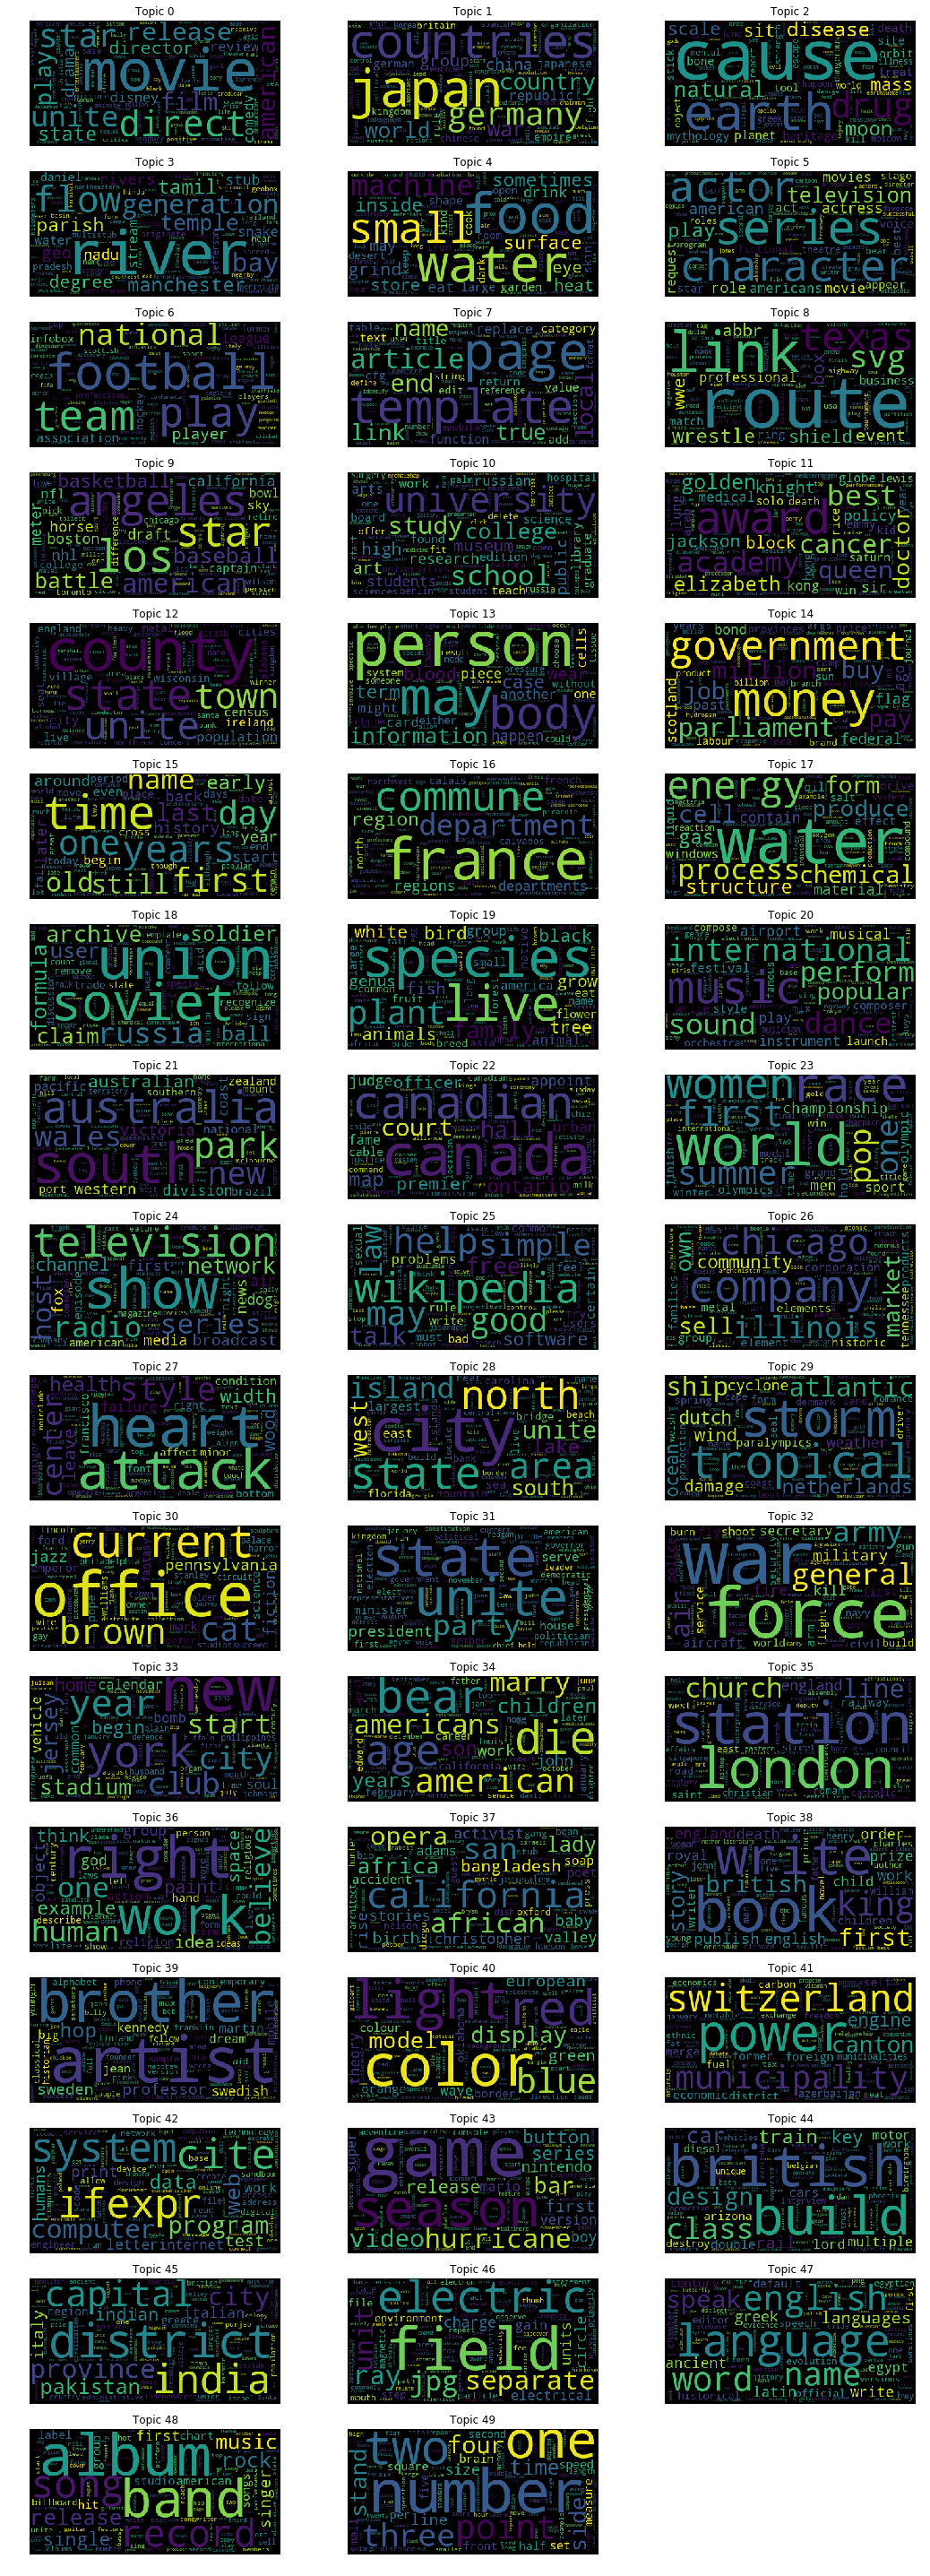

In [5]:
if __name__ == '__main__':

# We select whether we want to check an email, read the csv from the splitted database or directly ingest the data    
    prepare_database=False
    train_model=True
    check_result=False

    stoplist = ['also use make people know many call include part find become like mean often different usually take with come give well get since type list say change see refer actually iii kinds ask would way something need things want every str =09 0909 image'.split(' ')][0]
    stop = set(list(stopwords.words('english'))+stoplist)
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()

    
    if prepare_database == True:
        print('Preparing the training dataset')
        dir_path = 'articles-corpus/'
        prepare_training(dir_path)
        print('Finished preparing the training dataset')


    if train_model == True:
        print('Running the model on the training dataset')
        t_start = time.time()
        corpus_path = "articles-corpus/"
        run_model(corpus_path)
        t_end = time.time()
        
        print("Finished! Time elapsed: %.2f [minutes]"
              % ((t_end - t_start) / 60. ), end='\n')
        
    if check_result == True:
        model_path = 'lda_model.pkl'
        run_examples(model_path)


        